In [1]:
import sys
from pathlib import Path

module_path = str(Path().resolve().parent / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from curvature.tvg import *
from curvature.curvature_utils import *
from soap_parser.matrix import *
from soap_parser.tvg import draw_reeb_graph

import soap_parser.report_parser as rp
import networkx as nx

# TODO : fix random seed

### Scenario A : Data Mule

In [2]:
scenario_a = "Data Mule"

edges_a = [(1, 2), (1, 3), (2, 4), (2, 5), (3, 6), (3, 7), (8, 9), (8, 10),
(9, 11), (9, 12), (10, 13), (10, 14), (15, 16), (15, 17), (16, 18), (16, 19),
(17, 20), (17, 21), (22, 23), (22, 24), (23, 25), (23, 26), (24, 27), (24, 28)]
edges_b = edges_a + [(0, 1), (0, 8)]
edges_c = edges_a + [(0, 15), (0, 22)]

a_list = 2 * [edges_a] + 2 * [edges_b] + 2 * [edges_a] + 2 * [edges_c]

matrix_a = IntervalMatrix(29, 29, labels = [str(k) for k in range(29)])
start = 0
for e in 10 * a_list:
    for i, j in e:
        matrix_a[i, j] |= P.closed(start, start + 1)
    start += 1
network_a = TemporalNetwork(matrix_a)
# print(f"A : critical times = {network_a.get_critical_times()}")

# rg_a = network_a.get_reeb_graph()
# draw_reeb_graph(rg_a)

# print(f"{[network_a.get_node_label(k) for k in network_a.graph.nodes()]}")
print(f"Network A has {len(network_a.graph.nodes())} nodes.")

Network A has 29 nodes.


### Scenario B : Starlink

In [3]:
scenario_b = "Starlink [20 Satellites]"

filepath = "./scenario_b.csv"
nodes, edges = rp.contact_analysis_report_parser(filepath)
nodes, edges = rp.filter_contact_plan(nodes, edges, substring_exclusion_list=["Mars", "Moon"])

matrix_b = rp.contact_plan_to_matrix(nodes, edges)
matrix_b = matrix_b.get_submatrix(list(range(20)), list(range(20)))
network_b = TemporalNetwork(matrix_b)

# rg_b = network_b.get_reeb_graph()
# draw_reeb_graph(rg_b)

# print(f"{[network_b.get_node_label(k) for k in network_b.graph.nodes()]}")
print(f"Network B has {len(network_b.graph.nodes())} nodes.")

Network B has 20 nodes.


### Scenario C : LunaNet

In [4]:
scenario_c = "LunaNet"

filepath = "./scenario_c.csv"
nodes, edges = rp.contact_analysis_report_parser(filepath)
nodes, edges = rp.filter_contact_plan(nodes, edges, substring_exclusion_list=["Mars", "Moon"])

matrix_c = rp.contact_plan_to_matrix(nodes, edges)
network_c = TemporalNetwork(matrix_c)
# print(network_c)

# rg_c = network_c.get_reeb_graph()
# draw_reeb_graph(rg_c)

# print(f"{[network_c.get_node_label(k) for k in network_c.graph.nodes()]}")
print(f"Network C has {len(network_c.graph.nodes())} nodes.")

Network C has 15 nodes.


### True Reeb Graphs

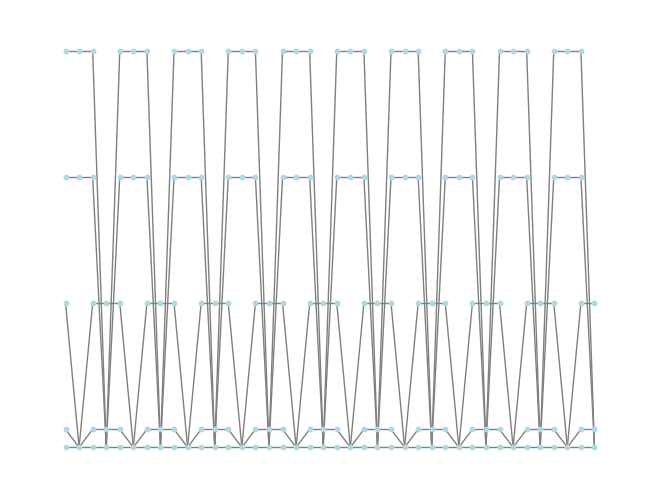

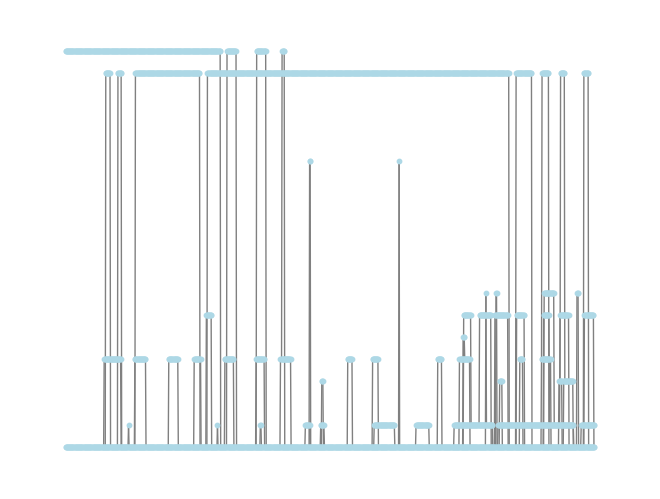

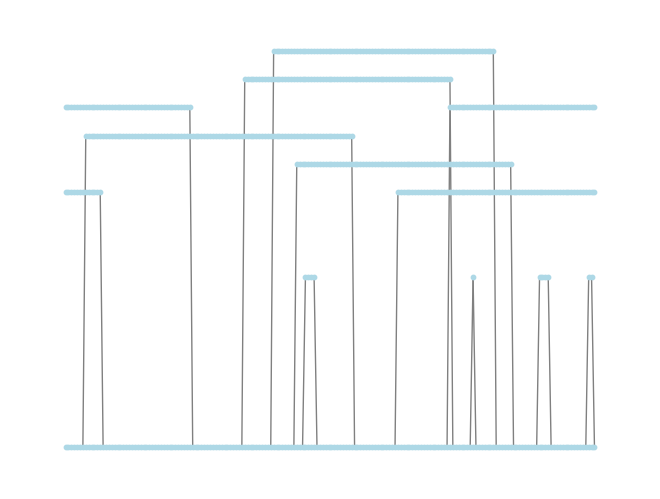

In [5]:
rg_a = network_a.get_reeb_graph()
draw_reeb_graph(rg_a)

rg_b = network_b.get_reeb_graph()
draw_reeb_graph(rg_b)

rg_c = network_c.get_reeb_graph()
draw_reeb_graph(rg_c)

### Evenly Sampled Reeb Graphs

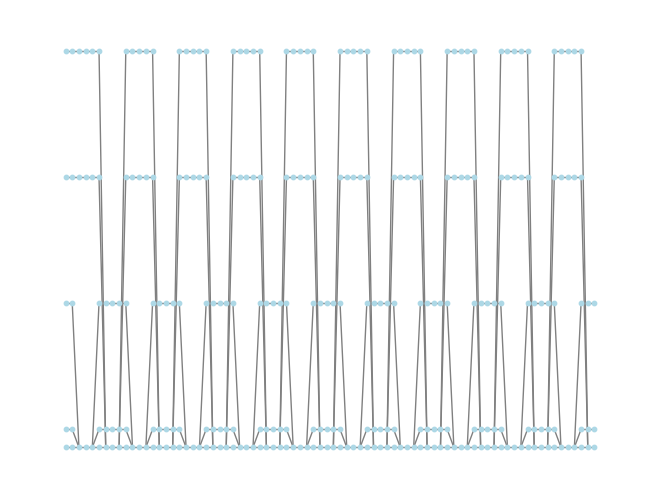

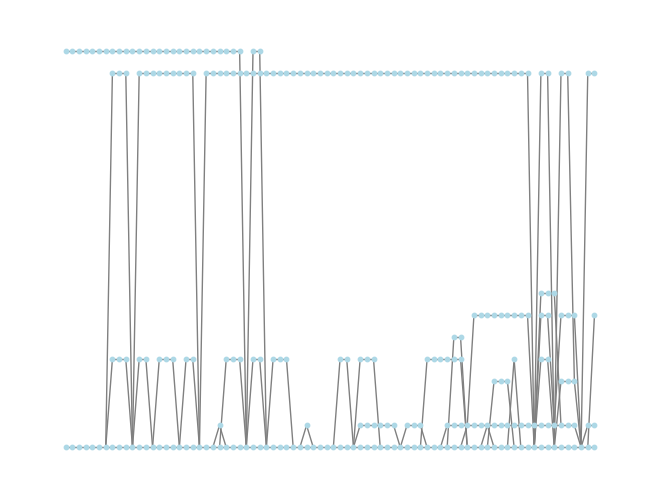

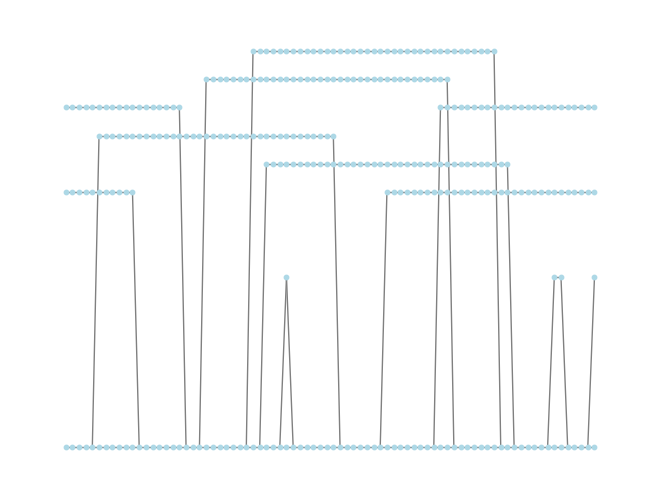

In [6]:
# scenario a : r = 1
rg_a = network_a.get_reeb_graph(np.arange(0, 80, 1).tolist())
draw_reeb_graph(rg_a)

# scenario's b and c : r = 1080
start_time, end_time, r = 0, 86400, 1080
sample_times = np.arange(start_time, end_time, r).tolist()

rg_b = network_b.get_reeb_graph(sample_times = sample_times)
draw_reeb_graph(rg_b)

rg_c = network_c.get_reeb_graph(sample_times = sample_times)
draw_reeb_graph(rg_c)

### Random Clusters

### Summary Graphs

0 : curvature_list_temp = ['(0,1) : c = -0.33333333333333326', '(0,8) : c = -0.33333333333333326', '(0,15) : c = -0.11111111111111101', '(0,22) : c = -0.11111111111111101', '(1,2) : c = -0.25', '(1,3) : c = -0.25', '(2,4) : c = -0.25', '(2,5) : c = -0.25', '(3,6) : c = -0.25', '(3,7) : c = -0.25', '(8,9) : c = -0.25', '(8,10) : c = -0.25', '(9,11) : c = -0.25', '(9,12) : c = -0.25', '(10,13) : c = -0.25', '(10,14) : c = -0.25', '(15,16) : c = -0.25', '(15,17) : c = -0.25', '(16,18) : c = -0.25', '(16,19) : c = -0.25', '(17,20) : c = -0.25', '(17,21) : c = -0.25', '(22,23) : c = -0.25', '(22,24) : c = -0.25', '(23,25) : c = -0.25', '(23,26) : c = -0.25', '(24,27) : c = -0.25', '(24,28) : c = -0.25']
1 : curvature_list_temp = ['(0,1) : c = -0.6666666666666665', '(0,8) : c = -0.6666666666666665', '(0,15) : c = -0.13333333333333322', '(0,22) : c = -0.13333333333333322', '(1,2) : c = -0.25', '(1,3) : c = -0.25', '(2,4) : c = -0.25', '(2,5) : c = -0.25', '(3,6) : c = -0.25', '(3,7) : c = -0.

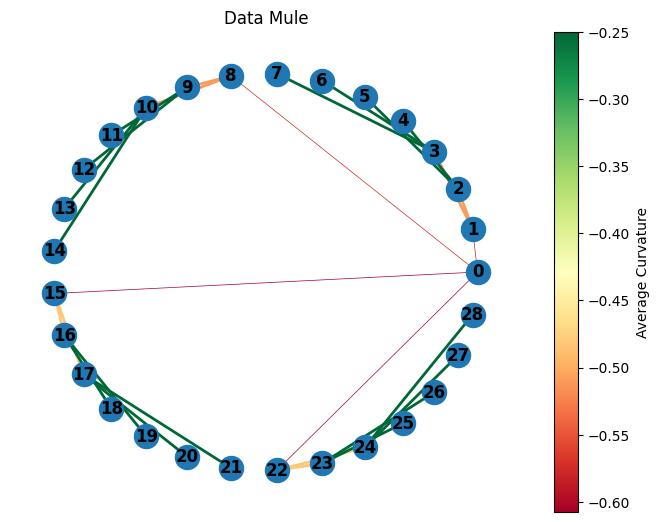

0:0
1:1
2:2
3:3
4:4
5:5
6:6
7:7
8:8
9:9
10:10
11:11
12:12
13:13
14:14
15:15
16:16
17:17
18:18
19:19
20:20
21:21
22:22
23:23
24:24
25:25
26:26
27:27
28:28
0 : curvature_list_temp = ['(0,1) : c = 0.0', '(0,2) : c = -1.375', '(0,3) : c = -0.03333333333333333', '(0,4) : c = -0.4374999999999998', '(0,5) : c = -0.03333333333333333', '(0,6) : c = -0.1', '(0,7) : c = 0.0555555555555557', '(0,8) : c = 0.25', '(0,9) : c = 0.25', '(0,10) : c = -0.5', '(0,11) : c = 0.04166666666666681', '(0,12) : c = -0.08333333333333333', '(0,13) : c = 0.45', '(0,14) : c = 0.18055555555555566', '(0,15) : c = 0.275', '(0,16) : c = 0.2500000000000001', '(0,17) : c = 0.2500000000000001', '(0,18) : c = 0.0', '(0,19) : c = 0.2500000000000001', '(1,3) : c = 0.13333333333333333', '(1,5) : c = 0.13333333333333333', '(1,6) : c = 0.5', '(1,7) : c = -0.16666666666666666', '(1,8) : c = 0.125', '(1,9) : c = 0.5', '(1,10) : c = 0.4', '(1,12) : c = 0.4583333333333333', '(1,13) : c = 0.0', '(1,14) : c = -0.1388888888888889', '(1

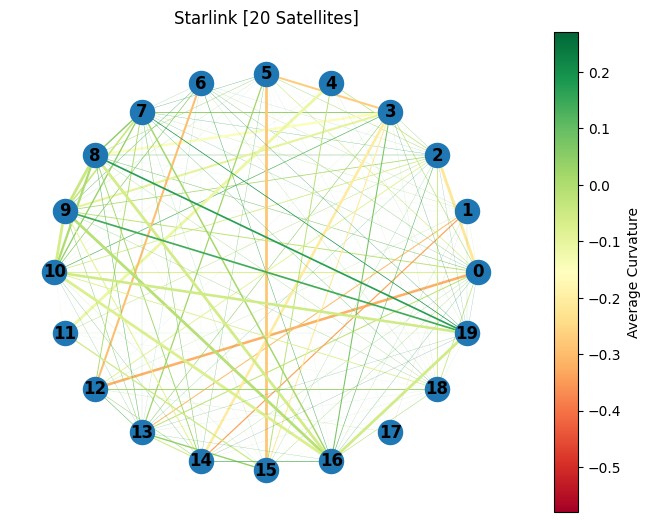

0:STARLINK-30858
1:STARLINK-30833
2:STARLINK-4206
3:STARLINK-31701
4:STARLINK-5012
5:STARLINK-3149
6:STARLINK-30700
7:STARLINK-31584
8:STARLINK-3342
9:STARLINK-5372
10:STARLINK-2651
11:STARLINK-1887
12:STARLINK-5952
13:STARLINK-5033
14:STARLINK-3982
15:STARLINK-30210
16:STARLINK-1730
17:STARLINK-11136 [DTC]
18:STARLINK-11182 [DTC]
19:STARLINK-4378
0 : curvature_list_temp = ['(0,1) : c = -0.16666666666666624', '(0,5) : c = 0.5', '(0,6) : c = 0.41666666666666685', '(0,8) : c = 0.4583333333333333', '(0,9) : c = 0.0', '(0,10) : c = 0.0', '(0,11) : c = 0.0', '(0,12) : c = 0.0', '(0,13) : c = 4.2106236193191124e-16', '(0,14) : c = 4.2106236193191124e-16', '(1,2) : c = -0.2142857142857144', '(1,3) : c = -0.125', '(1,4) : c = -0.125', '(1,5) : c = 0.0', '(1,6) : c = -0.16666666666666666', '(1,8) : c = 0.0', '(1,9) : c = 1.5311358615705863e-16', '(1,10) : c = 0.0', '(1,11) : c = 0.0', '(1,12) : c = 0.0', '(1,13) : c = -0.047619047619047526', '(1,14) : c = -0.047619047619047526', '(2,5) : c = 0.

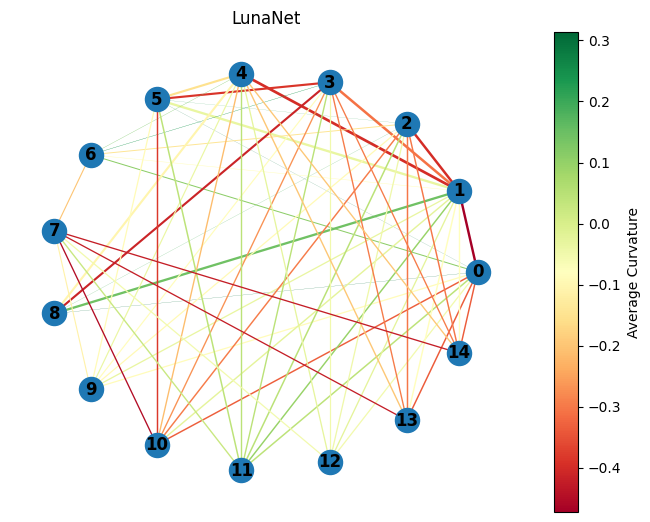

0:IOAGNorth1
1:Gateway
2:IOAGNorth2
3:IOAGSouth1
4:IOAGSouth2
5:LunarBase
6:LunarRoverFar
7:IOAGEquatorial
8:LunarRoverNear
9:DSN:Canberra
10:DSN:Goldstone
11:DSN:Madrid
12:LEGS:Dongara
13:LEGS:Wallops
14:LEGS:WhiteSands


In [7]:
# network_a.get_summary_graph()
K = 1
r = 1080

draw_summary_graph(network_a, title = scenario_a)
print(f"{network_a:n}")

draw_summary_graph(network_b, title = scenario_b, K = K, r = r)
print(f"{network_b:n}")

draw_summary_graph(network_c, title = scenario_c, K = K, r = r)
print(f"{network_c:n}")



### Bottleneck Analysis

0 : curvature_list_temp = ['(0,1) : c = 0.0', '(0,14) : c = 0.0', '(1,2) : c = 0.0', '(2,3) : c = 0.0', '(3,4) : c = 0.0', '(4,5) : c = 0.0', '(5,6) : c = 0.0', '(6,7) : c = 0.0', '(7,8) : c = 0.0', '(8,9) : c = 0.0', '(9,10) : c = 0.0', '(10,11) : c = 0.0', '(11,12) : c = 0.0', '(12,13) : c = 0.0', '(13,14) : c = 0.0']
1 : curvature_list_temp = ['(0,1) : c = 0.0', '(0,14) : c = 0.0', '(1,2) : c = 0.0', '(2,3) : c = 0.0', '(3,4) : c = 0.0', '(4,5) : c = 0.0', '(5,6) : c = 0.0', '(6,7) : c = 0.0', '(7,8) : c = 0.0', '(8,9) : c = 0.0', '(9,10) : c = 0.0', '(10,11) : c = 0.0', '(11,12) : c = 0.0', '(12,13) : c = 0.0', '(13,14) : c = 0.0']
2 : curvature_list_temp = ['(0,1) : c = 0.0', '(0,14) : c = 0.0', '(1,2) : c = 0.0', '(2,3) : c = 0.0', '(3,4) : c = 0.0', '(4,5) : c = 0.0', '(5,6) : c = 0.0', '(6,7) : c = 0.0', '(7,8) : c = 0.0', '(8,9) : c = 0.0', '(9,10) : c = 0.0', '(10,11) : c = 0.0', '(11,12) : c = 0.0', '(12,13) : c = 0.0', '(13,14) : c = 0.0']
3 : curvature_list_temp = ['(0,1) 

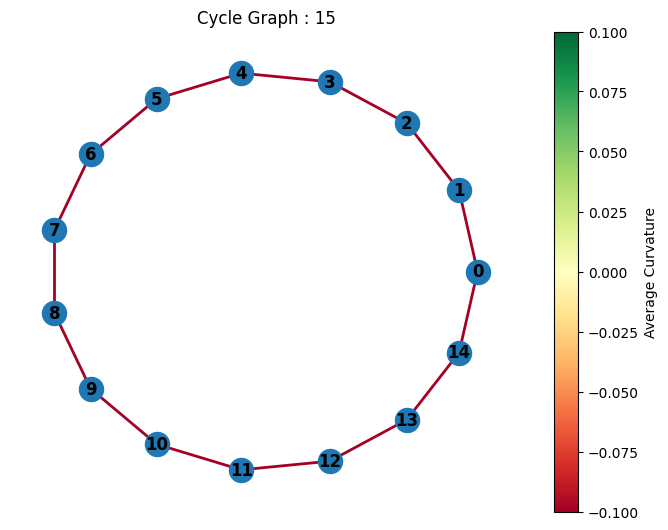

0 : curvature_list_temp = ['(0,1) : c = 1.1102230246251565e-16', '(0,2) : c = 1.1102230246251565e-16', '(0,3) : c = 1.1102230246251565e-16', '(0,4) : c = 1.1102230246251565e-16', '(0,5) : c = 1.1102230246251565e-16', '(0,6) : c = 1.1102230246251565e-16', '(0,7) : c = 1.1102230246251565e-16', '(0,8) : c = 1.1102230246251565e-16', '(0,9) : c = 1.1102230246251565e-16', '(0,10) : c = 1.1102230246251565e-16', '(0,11) : c = 1.1102230246251565e-16', '(0,12) : c = 1.1102230246251565e-16', '(0,13) : c = 1.1102230246251565e-16', '(0,14) : c = 1.1102230246251565e-16', '(1,2) : c = 1.1102230246251565e-16', '(1,3) : c = 1.1102230246251565e-16', '(1,4) : c = 1.1102230246251565e-16', '(1,5) : c = 1.1102230246251565e-16', '(1,6) : c = 1.1102230246251565e-16', '(1,7) : c = 1.1102230246251565e-16', '(1,8) : c = 1.1102230246251565e-16', '(1,9) : c = 1.1102230246251565e-16', '(1,10) : c = 1.1102230246251565e-16', '(1,11) : c = 1.1102230246251565e-16', '(1,12) : c = 1.1102230246251565e-16', '(1,13) : c = 1

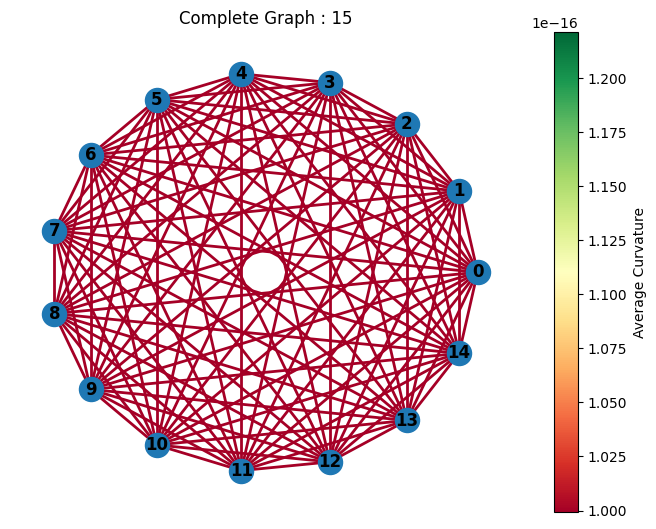

In [8]:
start, end = 0, 20

network = build_cycle_tvg(n := 15, start = start, end = end)
draw_summary_graph(network, title = f"Cycle Graph : {n}")

network = build_complete_tvg(n := 15, start = start, end = end)
draw_summary_graph(network, title = f"Complete Graph : {n}")
